In [1]:
mp_pdf = True
import django, sys, os
if mp_pdf:
    extension = "pdf"
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [8,6]
    }
    matplotlib.rcParams.update(pgf_with_latex)
    #matplotlib.rcParams['font.size'] = 6
else:
    extension = "png"
    import matplotlib as mpl
    mpl.rcParams['font.size'] = 6


import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np
from django.utils import timezone

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *

from django.db.models import Count, Sum

In [2]:
print(f"{Project.objects.count()} projects")

148 projects


In [3]:
users = User.objects.all()

active_users = users.filter(last_login__gt=timezone.now()-timedelta(weeks=4))

print(f"{users.count()} accounts, {active_users.count()} logged in in last 4 weeks")

177 accounts, 24 logged in in last 4 weeks


In [4]:
mcc_users = User.objects.filter(email__icontains="mcc-berlin") | User.objects.filter(username__icontains="mcc-berlin")
mcc_users = mcc_users.distinct()
external_users = User.objects.exclude(id__in=mcc_users.values_list('id',flat=True))

print(f"{mcc_users.count()} MCC accounts, {external_users.count()} external accounts")

37 MCC accounts, 140 external accounts


In [5]:

udf = pd.DataFrame.from_dict(list(users.values('date_joined').order_by('date_joined')))

udf['cumsum'] = udf.index

udf.plot(x="date_joined",y="cumsum", label="Users")

In [6]:

fig, ax = plt.subplots(figsize=(8,5))

udf = pd.DataFrame.from_dict(list(users.values('last_login').order_by('last_login')))

udf['cumsum'] = udf.index

udf.plot(x="last_login",y="cumsum", label="Users",ax=ax)

In [7]:
print(f"{Doc.objects.count():,} documents")

2,446,366 documents


In [8]:
dos = DocOwnership.objects.filter(relevant__in=[1,2,3])

print(DocOwnership.objects.filter(relevant__gt=0,finish__isnull=True).count())

print(f"{dos.count():,} document ratings")

26290
90,689 document ratings


In [9]:
rels = list(dos.values('relevant').annotate(n=Count('pk')).order_by('-n'))

for r in rels: # get the full name of relevance
    r['relevant'] = DocOwnership.Status[r['relevant']][1]    

dodf = pd.DataFrame.from_dict(rels)

fig, ax = plt.subplots()

ax.bar(dodf.index,dodf['n'])
ax.set_xticks(dodf.index)
ax.set_xticklabels(dodf['relevant'])

plt.show()


In [14]:
matplotlib.rcParams['font.size'] = 14

dos = DocOwnership.objects.filter(relevant__gt=0)
dodf = pd.DataFrame.from_dict(list(dos.values('date').order_by('date')))

dodf['cumsum'] = dodf.index

fig, ax = plt.subplots(figsize=(8,5))

dodf.plot(x="date",y="cumsum", label="Document ratings", ax=ax)



plt.savefig(f'plots/ratings_time.{extension}', bbox_inches="tight")

In [11]:
dos = DocOwnership.objects.filter(relevant__gt=0)
dodf = pd.DataFrame.from_dict(list(dos.values('finish','start').order_by('finish')))

dodf['time'] = dodf['finish'] - dodf['start']

dodf.head()

,finish,start,time
0,2018-06-25 20:49:44.595003+00:00,2018-08-14 12:55:11.218028+00:00,-50 days +07:54:33.376975
1,2018-06-25 20:50:54.044504+00:00,2018-06-25 20:49:45.118759+00:00,0 days 00:01:08.925745
2,2018-06-25 20:51:41.587927+00:00,2018-06-25 20:50:54.534373+00:00,0 days 00:00:47.053554
3,2018-06-25 20:55:01.967982+00:00,2018-06-25 20:54:55.210001+00:00,0 days 00:00:06.757981
4,2018-06-25 20:55:54.345456+00:00,2018-06-25 20:55:02.374725+00:00,0 days 00:00:51.970731


In [12]:
tms = RunStats.objects.filter(query__isnull=False)
topics = Topic.objects.filter(run_id__in=tms)
terms = Term.objects.filter(run_id__in=tms)

print(f"{tms.count()} topic models run")

print(f"{topics.count():,} topics")

print(f"{terms.count():,} terms")

671 topic models run
29,942 topics
11,786,504 terms


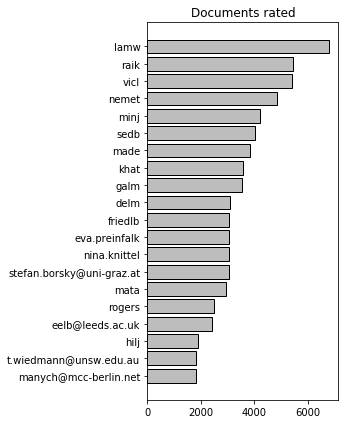

In [13]:
users = DocOwnership.objects.filter(
    relevant__gt=0
).values('user__username').annotate(
    n = Count('pk')
).order_by('-n')[:20]

udf = pd.DataFrame.from_dict(list(users)).sort_values('n').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(5,6))

ax.barh(udf.index,udf['n'],color="#bdbdbd",edgecolor="black")
ax.set_yticks(udf.index)
ax.set_yticklabels(udf['user__username'])

ax.set_title('Documents rated')

plt.tight_layout()

plt.savefig('user_ratings.png')

plt.show()